In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle as pkl
import imageio
import time
import os
import glob

In [2]:
lattice_size = 100
J = 1
h = 0
SEED_INDEX = 10
directory_initial = '/Users/burakcivitcioglu/Documents/doctorat/ising/notebooks'
directory_data = '/Users/burakcivitcioglu/Documents/doctorat/ising/train_data'

In [3]:
def file_name(lattice_size,J,h,T,seed,n):
    return f'SQ_L_{lattice_size}_J_{J:.2f}_h_{h:.2f}_T_{T:.2f}_s_{seed}_n_{n}'

def directory_name(lattice_size,J,h,T):
    return f'SQ_L_{lattice_size}_J_{J:.2f}_h_{h:.2f}_T_{T:.2f}'

def read_data(seed,n):
    
    '''
    The function reads all data as pkl files of all the temperatures given seed and n. 
    We need to call the function inside the directory where the data is
    located as directories. E.g. ising_lattice/*_T_0.5_*/ ... ising_lattice/
    *_T_9.0_*/
    '''
    os.chdir(directory_data)


    #T_init = 0.5
    #T_final = 9
    MAIN_DIRECTORY = "ising_data"
    # We define the T_index as the index number of the values of T
    # written in the file name, seperated by "_". So in this case e.g.
    # file_name = ...._T_1545_seed_1001 
    # index: 2 gives value of lattice size
    # index: 10 gives value of "seed"
    # index from last: 3 gives 1545 i.e. the value of T
    
    L_INDEX = 2
    J_INDEX = 4
    H_INDEX = 6
    T_INDEX = 8

    # We scale up the T values to search and parse directories
    
    # Get a numpy array of all the subdirectories
    sub_directories = np.asarray([f.path for f in os.scandir(MAIN_DIRECTORY) if f.is_dir()])
    # Now we parse the T values from the directory names
    parsed_T_values = np.zeros(sub_directories.size)
    
    for dir_names in np.arange(sub_directories.size):
        # First we split the directory names with "_"
        sub_directories[dir_names] = sub_directories[dir_names].lstrip(MAIN_DIRECTORY + "/")
        split_directory_name = np.asarray(sub_directories[dir_names].split("_"))
        # Now we take the file names that fit our needs
        condition = split_directory_name[L_INDEX].astype(int) == lattice_size and \
                    split_directory_name[J_INDEX].astype(float)==J and \
                    split_directory_name[H_INDEX].astype(float) == h
        if condition:
            # Now we take the T values. 
            parsed_T_values[dir_names] = split_directory_name[T_INDEX]



    # Now we trim all the zeros, and make sure everything is sorted as integers
    # Since our file names are integeres
    parsed_T_values = np.sort(parsed_T_values)


    os.chdir(MAIN_DIRECTORY)
    # Now we have everything needed to create our filenames and read it
    data = {}

    for files in np.arange(parsed_T_values.size):
        f_name = file_name(lattice_size, J,h,parsed_T_values[files],seed,n)
        d_name = directory_name(lattice_size, J,h,parsed_T_values[files])
        os.chdir(d_name)
        
        key_name = str(parsed_T_values[files])
        open_file = open(f_name + ".pkl",'rb')
        data_sample = pkl.load(open_file)
        data.update({key_name: data_sample})
        os.chdir('..')
    os.chdir(directory_initial)
    return data

def get_seeds():
    
    '''
    In order for the function to work properly, we need to be inside the 
    directory where the data FILES are located
    '''
    pkl_files_list = np.array(glob.glob('*.pkl'))
    seeds = np.zeros(pkl_files_list.size)
    for i in np.arange(pkl_files_list.size):
        seeds[i] = pkl_files_list[i].split("_")[SEED_INDEX]
    seeds = np.unique(seeds).astype(int)
    return seeds

def get_configurations(seed,n):
    
    '''
    The function gets configurations of all the temperatures given seed and n. 
    We need to call the function inside the directory where the data is
    located as directories. E.g. ising_lattice/*_T_0.5_*/ ... ising_lattice/
    *_T_9.0_*/
    '''

    # First we get the data
    data = read_data(seed,n)
    if data == []:
        print("There is no such data.")
        return None,None
    # Let us extract the keys i.e. temperatures (scaled up temperatures)
    keys = np.array(list(data.keys())).astype(np.float)


    # Initialize configurations array
    configurations = np.zeros((keys.size,lattice_size, lattice_size))
    
    # We iterate to get all the configurations in one array  
    for i in np.arange(keys.size):
        configurations[i] = data[keys[i].astype(str)]['configuration']
        
    # Now first element of keys array, is the temperature of
    # the first element of configurations array.
    return keys, configurations

def get_energies(seed, n, plot=False):
    
    '''
    The function gets energies of all the temperatures given seed and n. 
    We need to call the function inside the directory where the data is
    located as directories. E.g. ising_lattice/*_T_0.5_*/ ... ising_lattice/
    *_T_9.0_*/
    '''
    # First we get the data
    data = read_data(seed,n)
    if data == []:
        print("There is no such data.")
        return None,None
    # Let us extract the keys i.e. temperatures (scaled up temperatures)
    keys = np.array(list(data.keys())).astype(np.float)


    # Initialize energies array
    energies = np.zeros(keys.size)
    
    # We iterate to get all the energies in one array  
    for i in np.arange(keys.size):
        energies[i] = data[keys[i].astype(str)]['energy']
    if plot:
        plt.scatter(keys, energies)
        file_name_fig = f'energies_s_{seed}_n_{n}.png'
        plt.savefig(file_name_fig)


    # Now first element of keys array, is the temperature of
    # the first element of energies array.
    return keys, energies

def get_magnetizations(seed, n, plot=False):
    
    '''
    The function gets magnetizations of all the temperatures given seed and n. 
    We need to call the function inside the directory where the data is
    located as directories. E.g. ising_lattice/*_T_0.5_*/ ... ising_lattice/
    *_T_9.0_*/
    '''
    # First we get the data
    data = read_data(seed,n)
    if data == []:
        print("There is no such data.")
        return None,None
    # Let us extract the keys i.e. temperatures (scaled up temperatures)
    keys = np.array(list(data.keys())).astype(np.float)


    # Initialize magnetizations array
    magnetizations = np.zeros(keys.size)
    
    # We iterate to get all the magnetizations in one array  
    for i in np.arange(keys.size):
        magnetizations[i] = data[keys[i].astype(str)]['magnetization']
    if plot:
        plt.scatter(keys, magnetizations)
        file_name_fig = f'magnetizations_s_{seed}_n_{n}.png'
        plt.savefig(file_name_fig)


    # Now first element of keys array, is the temperature of
    # the first element of magnetizations array.
    return keys, magnetizations

def get_correlation_lengths(seed, n, plot=False):
    
    '''
    The function gets correlation lengths of all the temperatures given seed and n. 
    We need to call the function inside the directory where the data is
    located as directories. E.g. ising_lattice/*_T_0.5_*/ ... ising_lattice/
    *_T_9.0_*/
    '''
    # First we get the data
    data = read_data(seed,n)
    if data == []:
        print("There is no such data.")
        return None,None
    # Let us extract the keys i.e. temperatures (scaled up temperatures)
    keys = np.array(list(data.keys())).astype(np.float)


    # Initialize energies array
    correlation_lengths = np.zeros(keys.size)
    
    # We iterate to get all the correlation lengths in one array  
    for i in np.arange(keys.size):
        correlation_lengths[i] = data[keys[i].astype(str)]['correlation_length']
    if plot:
        plt.scatter(keys, correlation_lengths)
        file_name_fig = f'correlation_lengths_s_{seed}_n_{n}.png'
        print(file_name_fig)
        plt.savefig(file_name_fig)
        plt.show()

    # Now first element of keys array, is the temperature of
    # the first element of correlation lengths array.
    return keys, correlation_lengths

def get_correlation_function(seed, n, plot=False):
    
    '''
    The function gets correlation lengths of all the temperatures given seed and n. 
    We need to call the function inside the directory where the data is
    located as directories. E.g. ising_lattice/*_T_0.5_*/ ... ising_lattice/
    *_T_9.0_*/
    '''
    # First we get the data
    data = read_data(seed,n)
    if data == []:
        print("There is no such data.")
        return None,None
    # Let us extract the keys i.e. temperatures (scaled up temperatures)
    keys = np.array(list(data.keys())).astype(np.float)
    distances = data['0.5']['distances']
    # Initialize energies array
    correlation_funcs = np.zeros((keys.size,distances.size))
    
    # We iterate to get all the energies in one array  
    for i in np.arange(keys.size):
        correlation_funcs[i] = data[keys[i].astype(str)]['correlation_function']
    if plot:
        plt.figure(0,figsize=(35,21))
        plots = []
        k=0
        for i in range(5):
            for j in range(6):
                ax = plt.subplot2grid((5,6), (i,j))
                ax.scatter(distances,correlation_funcs[k],label=f'T={keys[k]}',marker=',')
                ax.legend(loc="upper right")
                k += 1
        file_name_fig = f'correlation_functions_s_{seed}_n_{n}.png'
        plt.savefig(file_name_fig)
        plt.show()
        
    return distances, correlation_funcs



In [4]:
data = read_data(seed = 14539,n = 0)

In [5]:
T, confs = get_configurations(seed = 14539,n = 0)

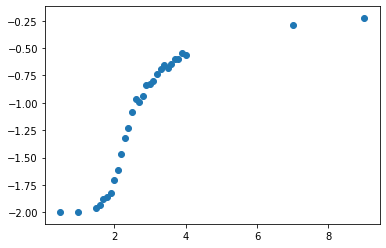

In [6]:
T, energies = get_energies(seed = 14539, n = 0,plot=True)

In [7]:
seeds = get_seeds()
print(seeds)

[]


correlation_lengths_s_14539_n_1000.png


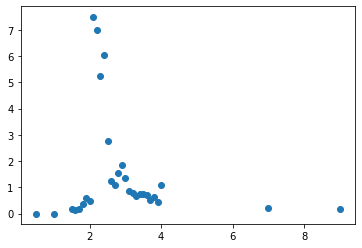

In [8]:
cor = get_correlation_lengths(seed = 14539, n = 1000,plot=True)

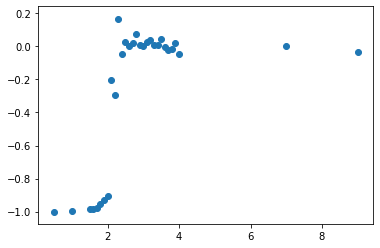

In [9]:
mag = get_magnetizations(seed = 14539, n = 1000,plot=True)

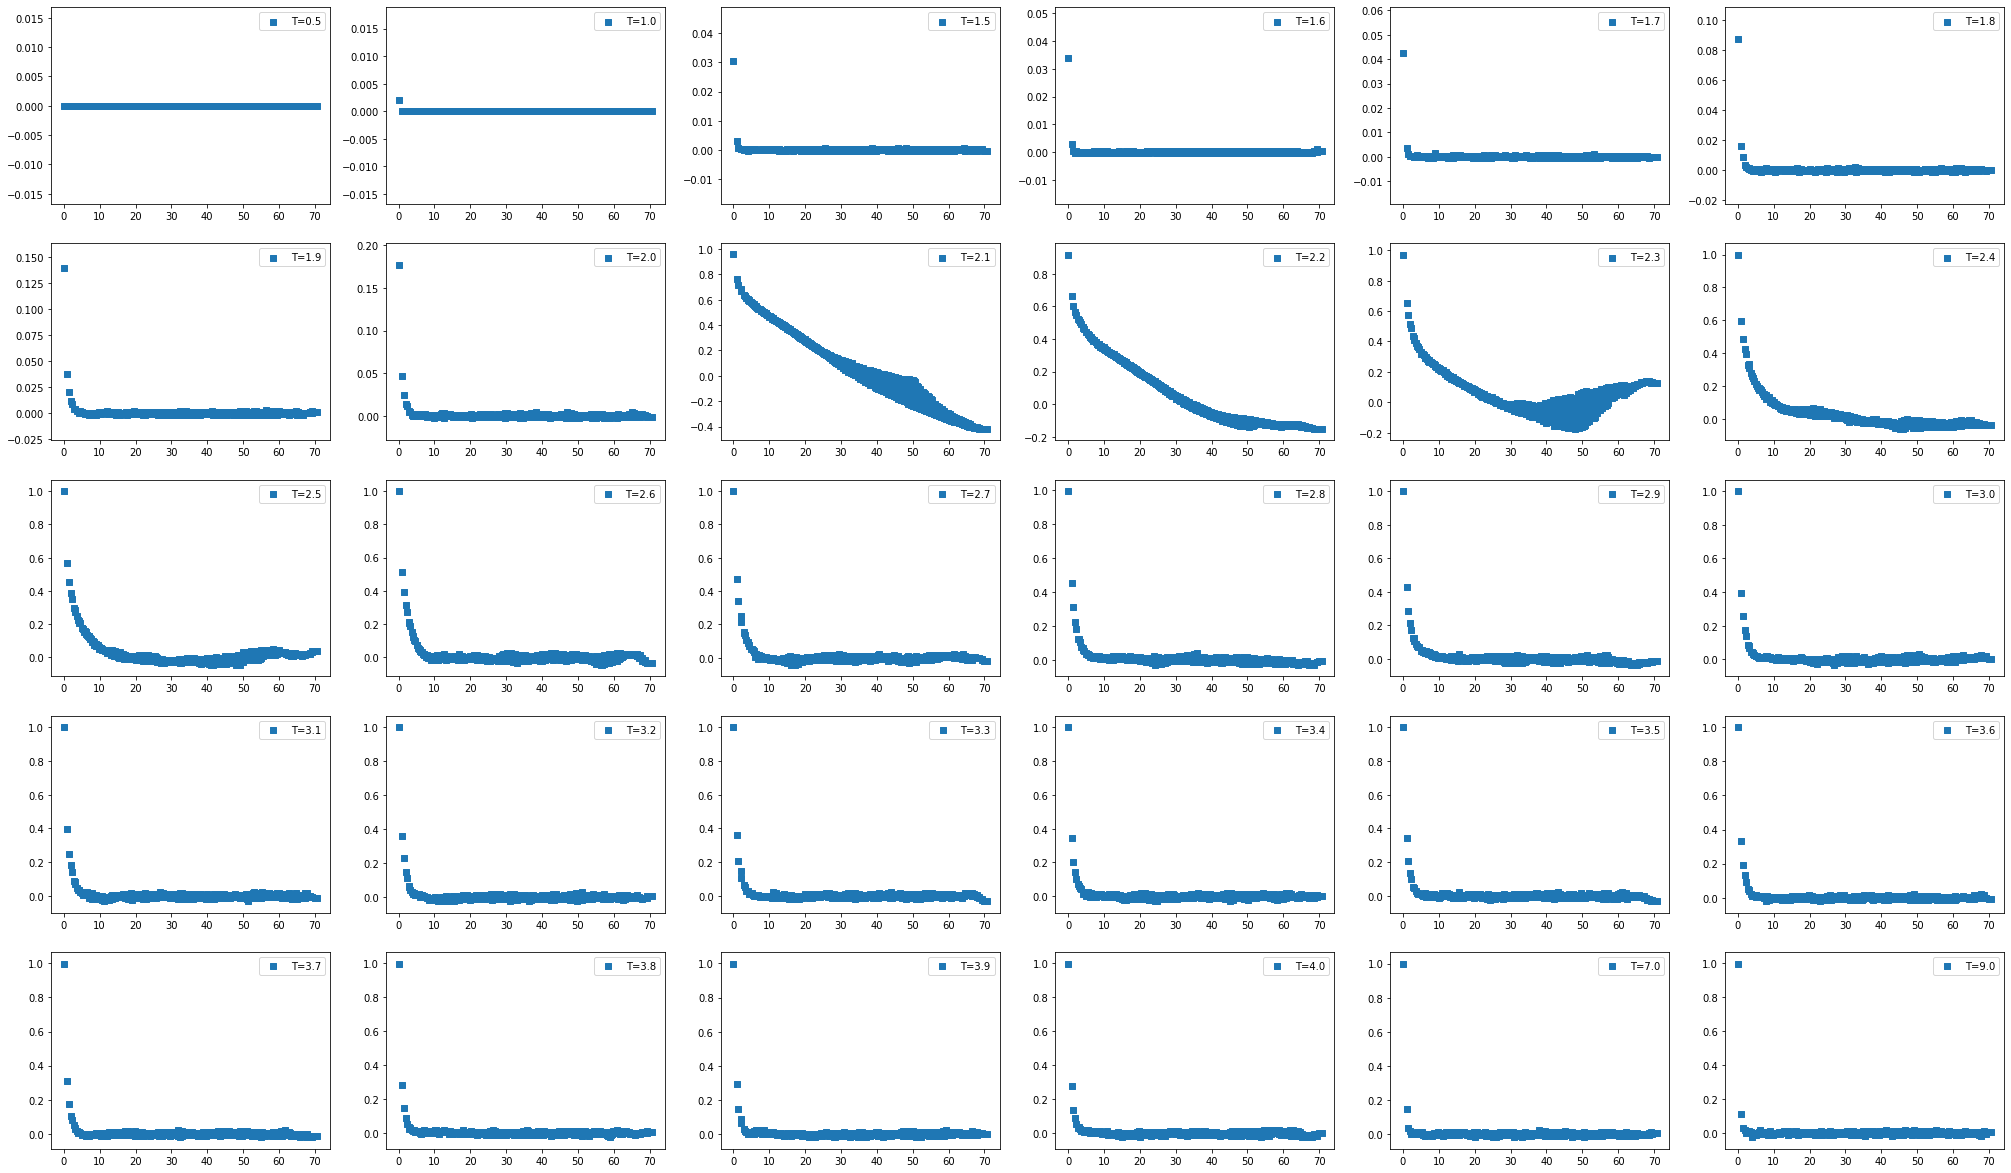

In [10]:
cor_f = get_correlation_function(seed = 14539, n = 1000,plot=True)